## Imports

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## TensorFlow GPU Check

In [2]:
# Check the tensorflow is detecting the gpu
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Hyperparameters

In [3]:
EPOCHS = 200
BATCH_SIZE = 128

IMG_HEIGHT = 256
IMG_WIDTH = 256

# Dataset directory
dataset_path = os.environ['DATASET_PATH']
#image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.jpeg')]
directory_path = pathlib.Path(dataset_path)



## Loading the Dataset using Keras

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    # image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    # image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


## EDA (Exploratory Data Analysis)

In [5]:
# Prints the Total Number of Images in the Dataset
print(f'Number of Images: ', len(list(directory_path.glob('*/*.jpeg'))))

Number of Images:  24209


In [6]:
# Prints the classifications of Animals from the Dataset
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [7]:
# Prints the Number of Images in each Class
for class_name in class_names:
    print(f'Number of {class_name} Images: ', len(list(directory_path.glob(f'{class_name}/*.jpeg'))))

Number of butterfly Images:  1650
Number of cat Images:  1227
Number of chicken Images:  3098
Number of cow Images:  1866
Number of dog Images:  4863
Number of elephant Images:  1079
Number of horse Images:  2623
Number of sheep Images:  1444
Number of spider Images:  4497
Number of squirrel Images:  1862


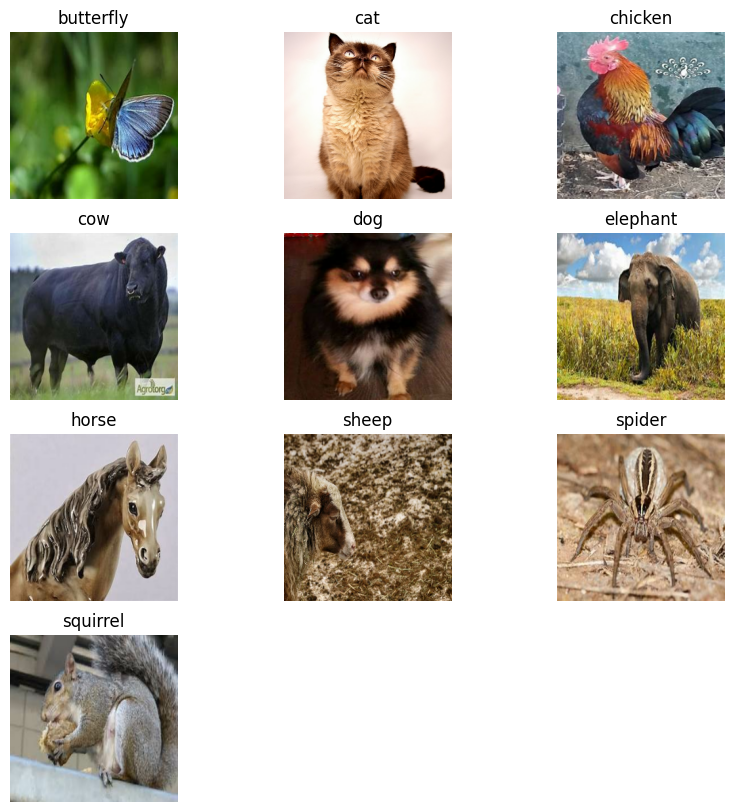

In [8]:
# Plots one image from each of the 10 classes
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(4, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

## Model

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 256, 256, 3)
(128,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Model Creation

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

## Training

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/100
164/164 [==============================] - 250s 2s/step - loss: 2.1058 - accuracy: 0.2890 - val_loss: 1.8012 - val_accuracy: 0.3769
Epoch 2/100
164/164 [==============================] - 18s 107ms/step - loss: 1.5365 - accuracy: 0.4754 - val_loss: 1.4252 - val_accuracy: 0.5108
Epoch 3/100
164/164 [==============================] - 18s 107ms/step - loss: 1.2166 - accuracy: 0.5885 - val_loss: 1.3002 - val_accuracy: 0.5649
Epoch 4/100
164/164 [==============================] - 18s 106ms/step - loss: 0.9643 - accuracy: 0.6775 - val_loss: 1.3588 - val_accuracy: 0.5614
Epoch 5/100
164/164 [==============================] - 18s 107ms/step - loss: 0.7647 - accuracy: 0.7452 - val_loss: 1.3871 - val_accuracy: 0.5794
Epoch 6/100
164/164 [==============================] - 18s 106ms/step - loss: 0.5532 - accuracy: 0.8162 - val_loss: 1.6102 - val_accuracy: 0.5757
Epoch 7/100
164/164 [==============================] - 18s 105ms/step - loss: 0.3804 - accuracy: 0.8789 - val_loss: 1.9447 - v

## Results

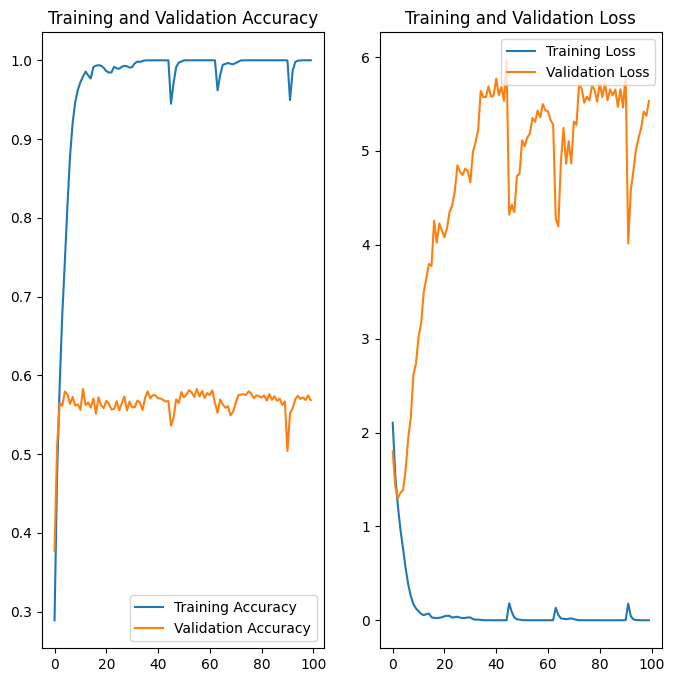

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Save the Model
model.save(os.path.join(os.environ['MODELS_PATH'], 'model.h5'))

In [19]:
# Take in an image and use the model to predict the class of the image
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        f'This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score)} percent confidence.'
    )

    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 115ms/step
This image most likely belongs to dog with a 81.83039426803589 percent confidence.


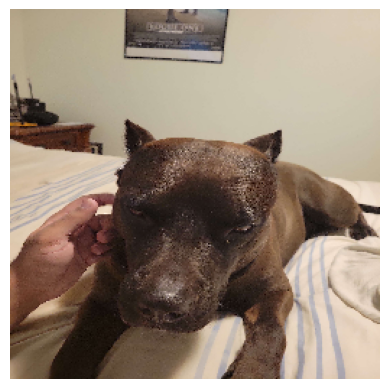

In [20]:
predict_image(os.path.join(os.environ['TEST_IMG_PATH'], 'dog.jpg'))